<a href="https://colab.research.google.com/github/Gunaranjan66/Machine-Learning/blob/master/MAML_Omniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks

   ___Intorduction___:  Artificial intelligence is trying to learn how to learn from the way humans learn. We can quickly and easily recognize a new object from just seeing one or few pictures of it, or even from only reading about it without having ever seen it before. We can learn quickly a new skill as well as master many different tasks. This seems easy for the human intelligence but for machines, it is quite a challenge to overcome. Berkeley AI Research Lab published a research paper introducing Model-Agnostic Meta-learning MAML which is a simple solution, yet so powerful and game-changing in meta-learning (or learning to learn).

In [0]:
#packages
import pandas as pd #data analysis
import torch       #Deep network model designer
from torch.utils.data import Dataset,DataLoader
from PIL import Image # Image processing
import torchvision.transforms as transforms #transformations
import torch.nn as nn #Nework layers
from collections import OrderedDict #creating dictionaries
import torch.nn.functional as F 
import random
import os
import urllib.request
import zipfile
import csv
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Downloading the data (omniglot)

Omniglot data set for one-shot learning. This dataset contains 1623 different handwritten characters from 50 different alphabets.<br/>
<li>This dataset is prepocessed and normalized</li>

In [0]:
def download_url(url, save_path):
    '''Args:
            url : path to download file
            save_path : file path to save to give url'''
    with urllib.request.urlopen(url) as dl_file:
        with open(save_path, 'wb') as out_file:
            out_file.write(dl_file.read())

In [3]:
directory="data"
if not os.path.isdir(directory):
    os.mkdir(directory)


#urls for data
urls = [
        'https://github.com/brendenlake/omniglot/raw/master/python/images_background.zip',
        'https://github.com/brendenlake/omniglot/raw/master/python/images_evaluation.zip'
    ]


for url in urls:
    filename = url.split('/')[-1]
    file_path = os.path.join(directory, filename)
    print('== Downloading ' + filename)
    download_url(url,file_path)
    print("== Unzip from " + file_path + " to " + directory)
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall(directory)
    zip_ref.close()
print("Completed Downloading")

== Downloading images_background.zip
== Unzip from data/images_background.zip to data
== Downloading images_evaluation.zip
== Unzip from data/images_evaluation.zip to data
Completed Downloading


## Labeling the data save it into csv file for later use

In [0]:
def labeling(folder,result_name):
    global assigned_label
    with open(result_name,'w') as csvfile:
        fields=['ID','Path','Label']
        csvwriter=csv.writer(csvfile,delimiter=',')
        csvwriter.writerow(fields)
        for a in os.listdir(folder):
            i=0
            for charfolder in os.listdir(folder+'/'+a):
                for image in os.listdir(folder+'/'+a+'/'+charfolder):
                    label=assigned_label
                    path=folder+'/'+a+'/'+charfolder+'/'+image
                    csvwriter.writerow([image,path,str(label)])
                assigned_label+=1

In [0]:
assigned_label=0
train_root='data/images_background'
test_root='data/images_evaluation'
labeling(train_root,"train.csv")
labeling(test_root,"test.csv")

Reading data from file which is created by above cell

In [0]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [33]:
train_data.sample(5)

,ID,Path,Label
5936,0413_13.png,data/images_background/Greek/character20/0413_...,296
19128,0480_18.png,data/images_background/Hebrew/character15/0480...,956
4614,0940_08.png,data/images_background/Tifinagh/character31/09...,230
1170,0875_18.png,data/images_background/Sanskrit/character25/08...,58
7205,0278_01.png,data/images_background/Syriac_(Estrangelo)/cha...,360


In [7]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Pre step for input the data into model

In [0]:
class MiniSet(Dataset):
    def __init__(self,fileroots,labels,transform):
      '''
      Args:
          fileroots:path of image file
          labels:output label to the fileroot image
          transform:transform applied on images
      '''
        self.fileroots=fileroots
        self.labels=labels
        self.transform=transform

    def __len__(self):
        return len(self.fileroots)

    def __getitem__(self,idx):
        img=Image.open(self.fileroots[idx])
        img=self.transform(img)
        return img,self.labels[idx]

In [0]:
class Task(object):
    def __init__(self,data,all_classes,num_classes,k_way,k_query,transforms):
      '''
        Args:
          data:pandas data frame that use for create task form it
          all_classes:Array of classes of output of data
          num_classes:Num classes is required for each task
          k_way:num for samples of each class for inner step
          k_query:num of sample for outer step update
          transform:transform applied on images
      '''
        self.all_classes=all_classes
        self.num_classes=num_classes
        self.train_roots=[]
        self.meta_roots=[]
        self.train_labels=[]
        self.meta_labels=[]
        samples_per_class=20
        self.transforms=transforms
        sampled_classes=random.sample(all_classes,num_classes)
        label=0
        val=int(data.iloc[0]["Label"])
        for c in sampled_classes:
            cframe=data.iloc[((c-val)*samples_per_class):(((c+1)-val)*samples_per_class)]
            cframe.reset_index(inplace=True,drop=True)
            paths=cframe["Path"]
            sample_idxs=np.random.choice(samples_per_class,samples_per_class,replace=False)
            train_idxs=sample_idxs[:k_way]
            meta_idxs=sample_idxs[k_way:(k_way+k_query)]
            for idx in train_idxs:
                self.train_roots.append(paths[idx])
                self.train_labels.append(label)
            for idx in meta_idxs:
                self.meta_roots.append(paths[idx])
                self.meta_labels.append(label)
            label+=1
    def get_loaders(self):
        loaders={}
        trainloader=DataLoader(MiniSet(self.train_roots,self.train_labels,self.transforms),
                             batch_size=len(self.train_roots),shuffle=True)
        testloader=DataLoader(MiniSet(self.meta_roots,self.meta_labels,self.transforms),
                             batch_size=len(self.meta_roots),shuffle=True)
        loaders["sample"]=trainloader
        loaders["query"]=testloader
        return loaders

## creating Model
![alt text](https://miro.medium.com/max/3744/1*SGPGG7oeSvVlV5sOSQ2iZw.png)

In [0]:
class BaseNet(nn.Module):
    def __init__(self,num_classes):
        super(BaseNet,self).__init__()
        '''Args:
                num_classed : number of output labels
            '''
        self.features = nn.Sequential(OrderedDict([  
                    ('conv1', nn.Conv2d(1, 64, 3)),  # 64x26x26
                    ('bn1', nn.BatchNorm2d(64, momentum=1, affine=True)),
                    ('relu1', nn.ReLU(inplace=True)),
                    ('pool1', nn.MaxPool2d(2,2)), #    64x13x13
                    ('conv2', nn.Conv2d(64,64,3)),  #  64x11x11
                    ('bn2', nn.BatchNorm2d(64, momentum=1, affine=True)),
                    ('relu2', nn.ReLU(inplace=True)),
                    ('pool2', nn.MaxPool2d(2,2)), #    64x5x5
                    ('conv3', nn.Conv2d(64,64,3)), #   64x3x3
                    ('bn3', nn.BatchNorm2d(64, momentum=1, affine=True)),
                    ('relu3', nn.ReLU(inplace=True)),
                    ('pool3', nn.MaxPool2d(2,2))]))  #64x1x1  
        self.fc= nn.Linear(64,num_classes) 

    def forward(self,x,weights=None):
        '''Args:
                x:input images (n x c x 28 x 28 size images)
                n:number of images
                c:number of color channels
            returns:
                    (n x num_classes) dimenstion array '''
        if weights==None:  
            output=self.features(x)
            output=output.view(-1,64)
            output=self.fc(output)
        else:
            x = F.conv2d(x, weights['features.conv1.weight'], weights['features.conv1.bias'])
            x = F.batch_norm(x, weights['features.bn1.running_mean'], 
                             weights['features.bn1.running_var'],
                              weights['features.bn1.weight'],
                             weights['features.bn1.bias'],momentum=1,training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2) 
            x = F.conv2d(x, weights['features.conv2.weight'], weights['features.conv2.bias'])
            x = F.batch_norm(x, weights['features.bn2.running_mean'], 
                             weights['features.bn2.running_var'],
                              weights['features.bn2.weight'],
                             weights['features.bn2.bias'],momentum=1,training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2) 
            x = F.conv2d(x, weights['features.conv3.weight'], weights['features.conv3.bias'])
            x = F.batch_norm(x, weights['features.bn3.running_mean'], 
                             weights['features.bn3.running_var'],
                              weights['features.bn3.weight'],
                             weights['features.bn3.bias'],momentum=1,training=True)
            x = F.relu(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2) 
            x = x.view(x.size(0), 64)
            output = F.linear(x, weights['fc.weight'], weights['fc.bias'])
        out = F.log_softmax(output, dim=1)
        return out
    def get_weights(self):
        model_weights = {key: val.clone() for key, val in self.state_dict().items()}
        return model_weights

# Inner_loop for MAML model
![alt text](https://image.slidesharecdn.com/maml-181130144044/95/introduction-to-maml-model-agnostic-meta-learning-with-discussions-19-638.jpg?cb=1543588892)

In [0]:
def train_single_task(net,lr,loaders,num_updates,loss_metric):
  '''
    Args:
      net:Model that used
      loaders:Data for inputing into model
      lr:learning rate for inner loop
      num_updates:number of time does inner loop get update the weights
      loss_metric:loss function
  '''
    net.train()
    trainloader=loaders["sample"]
    x,y=trainloader.__iter__().next()
    x.to(device)
    y.to(device)
    output=net(x)
    loss=loss_metric(output,y)
    def zero_grad(params):
        for p in params:
            if p.grad is not None:
                p.grad.zero_()
    zero_grad(net.parameters())
    grads=torch.autograd.grad(loss,net.parameters(),create_graph=True)
    mod_state_dict=net.get_weights()
    mod_weights=OrderedDict()
    for (k,v),g in zip(net.named_parameters(),grads):
        mod_weights[k]=v-lr*g
        mod_state_dict[k]=mod_weights[k]
    for i in range(1,num_updates):
        output=net(x,mod_state_dict)
        loss=loss_metric(output,y)
        zero_grad(mod_weights.values())
        grads=torch.autograd.grad(loss,mod_weights.values(),create_graph=True)
        for (k,v),g in zip(mod_weights.items(),grads):
            mod_weights[k]=v-lr*g
            mod_state_dict[k]=mod_weights[k]
    return mod_state_dict

# Traing the model

In [0]:
def train(net,meta_train_classes,meta_optimiser,loss_metric,transforms,num_classes,
          k_way,k_query,num_tasks,lr,meta_lr,num_inner_updates,num_epochs):   
  '''
    Args:
      net:Model
      meta_train_classes:Total class in the data
      meta_optimiser:optimizer for outer loop
      loss_metric:Loss function
      transforms:transforms applied on data
      num_classes:Number of classes on each task
      k_way:number of images on each class for each task for inner loop
      k_query:number of images on each class for each task for outer loop
      lr:learning rate for inner loop
      meta_lr:learning rate for meta update(outer loop)
      num_inner_updates:number of time does inner loop get update the weights
  '''
    total_loss=0
    meta_losses=[]
    for epoch in range(1,num_epochs+1):
        state_dicts=[]
        loaders_list=[]
        for n in range(num_tasks):
            task=Task(train_data,meta_train_classes,num_classes,k_way,k_query,transforms)
            loaders=task.get_loaders()
            d=train_single_task(net,lr,loaders,num_inner_updates,loss_metric)
            state_dicts.append(d)
            loaders_list.append(loaders)
        metaloss=0
        for n in range(num_tasks):
            loaders=loaders_list[n]
            metaloader=loaders["query"]
            x,y=metaloader.__iter__().next()
            x.to(device)
            y.to(device)
            d=state_dicts[n]
            output=net(x,d)
            loss=loss_metric(output,y)
            metaloss+=loss
        metaloss/=float(num_tasks)
        total_loss+=metaloss.item()
        meta_optimiser.zero_grad()
        metaloss.backward()
        meta_optimiser.step()
        if (epoch % 10) == 0:
            print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / 2))
        if (epoch%2)==0:
            meta_losses.append(total_loss/2)
            total_loss = 0
    return meta_losses,net

In [22]:
loss_metric=nn.NLLLoss()
num_classes=5
net=BaseNet(num_classes)
lr=1e-1
meta_lr=1e-3
meta_optimizer = torch.optim.Adam(net.parameters(), lr=meta_lr)
k_way=10
k_query=10
num_tasks=10
num_inner_updates=1
num_epochs=100
train_classes=np.max(train_data['Label'])
train_classes=list(np.arange(train_classes))
transform=transforms.Compose([transforms.Resize((28,28)),transforms.ToTensor()])
metalosses,net=train(net,train_classes,meta_optimizer,loss_metric,transform,
                     num_classes,k_way,k_query,num_tasks,lr,meta_lr,
                     num_inner_updates,num_epochs)

10/100. loss: 0.6642213463783264
20/100. loss: 0.510557621717453
30/100. loss: 0.3551229238510132
40/100. loss: 0.3085741251707077
50/100. loss: 0.28945405781269073
60/100. loss: 0.24506106972694397
70/100. loss: 0.21089977771043777
80/100. loss: 0.20205962657928467
90/100. loss: 0.20156239718198776
100/100. loss: 0.18115905672311783


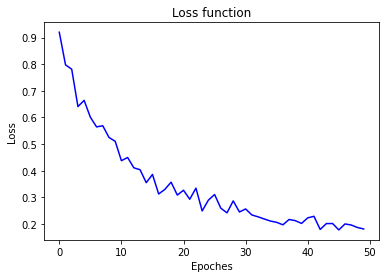

In [23]:
plt.plot(metalosses,color='b')
plt.title("Loss function")
plt.xlabel("Epoches")
plt.ylabel("Loss")
plt.show()

<h1>Evaluation on test_data</h1><br/>
<p>Taking sample's form the test data and perform the MAML on the sample 

In [0]:
def accuracy(outputs, labels):
  outputs = np.argmax(outputs, axis=1)
  return np.sum(outputs == labels) / float(labels.size)
def evaluate(net,test_classes,task_lr,transform,num_classes=3,num_steps=100,k_way=3,k_query=5,num_eval_updates=5):
    losses=[]
    acc_list=[]
    for step in np.arange(num_steps):
        task=Task(test_data,test_classes,num_classes=num_classes,k_way=k_way,k_query=k_query,transforms=transform)
        loaders=task.get_loaders()
        trainloader,testloader=loaders["sample"],loaders["query"]
        x_train,y_train=trainloader.__iter__().next()
        x_test,y_test=testloader.__iter__().next()
        x_train.to(device)
        y_train.to(device)
        x_test.to(device)
        y_test.to(device)
        cloned_net=copy.deepcopy(net)
        optim = torch.optim.SGD(cloned_net.parameters(),lr=task_lr)
        for _ in range(num_eval_updates):
            y_train_pred=cloned_net(x_train)
            loss=loss_metric(y_train_pred,y_train)
            optim.zero_grad()
            loss.backward()
            optim.step()
        y_test_pred=cloned_net(x_test)
        loss=loss_metric(y_test_pred,y_test)
        losses.append(loss)
        y_test_pred=y_test_pred.data.cpu().numpy()
        y_test=y_test.data.cpu().numpy()
        acc=accuracy(y_test_pred,y_test)
        if step%10==0:
          print("accuracy is: ",acc)
        acc_list.append(acc)
    return acc_list,losses

In [30]:
import copy
#test_classes=np.max(testframe['Label'])-np.min(testframe['Label'])
test_classes=list(np.arange(np.min(test_data['Label']),np.max(test_data['Label']+1)))
acc_list,losses=evaluate(net,test_classes,task_lr=1e-1,transform=transform,k_way=k_way,k_query=k_query )

accuracy is:  0.9666666666666667
accuracy is:  1.0
accuracy is:  1.0
accuracy is:  0.9
accuracy is:  1.0
accuracy is:  1.0
accuracy is:  0.9666666666666667
accuracy is:  1.0
accuracy is:  1.0
accuracy is:  1.0


From the above output it predicts better event though training sample are less